In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython import display
import matplotlib.gridspec as gridspec

from matplotlib import animation

In [3]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs = torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

def generate_2Dgrid(range1, range2, Ns, requires_grad = True):
    grid1 = np.linspace(range1[0], range1[1], Ns[0], dtype = np.float32)
    grid2 = np.linspace(range2[0], range2[1], Ns[1], dtype = np.float32)
    x0, y0 = np.meshgrid(grid1, grid2)
    x = torch.tensor(x0.reshape(Ns[0]*Ns[1], 1), requires_grad = requires_grad)
    y = torch.tensor(y0.reshape(Ns[0]*Ns[1], 1), requires_grad = requires_grad)
    return x, y

In [4]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()
        
        self.lam = nn.Parameter(torch.tensor(5.0, requires_grad = True))

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x) * x * (1 - x) 

In [5]:
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode
        
    def forward(self, x):
        f  = self.ode(x)
        d2f = gradients(f, x, 2)
                
        loss = torch.mean((d2f + f*self.ode.lam**2)**2) + (torch.mean(torch.abs(f)) - 1)**2
        
        return loss

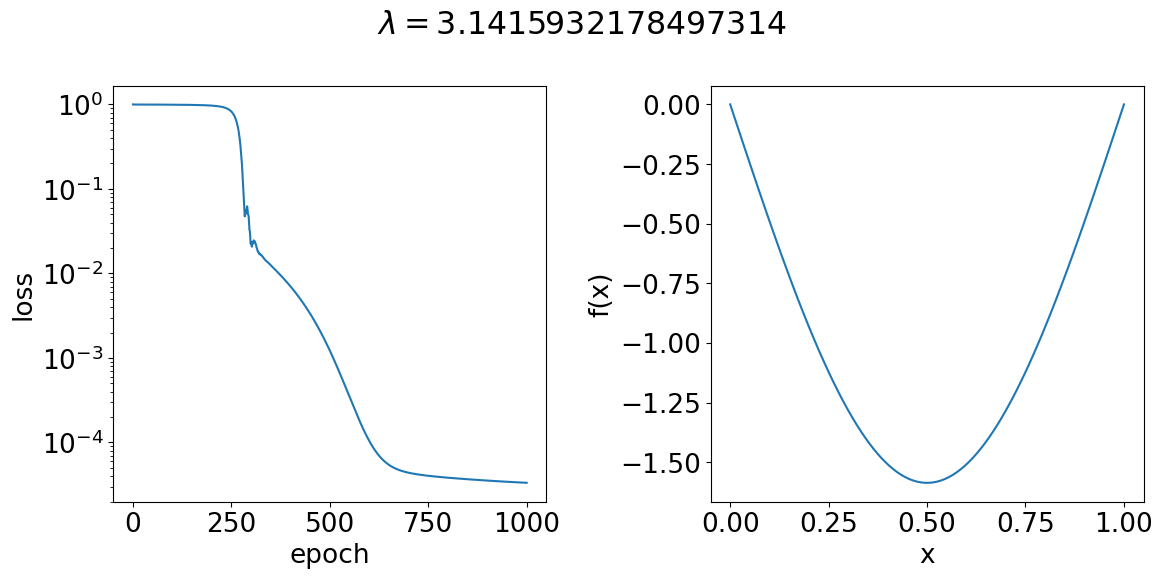

In [6]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []

optimizer = optim.Adam(ode.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01)**(1/2000))
x = torch.tensor(np.linspace(0, 1, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(1001):
    try:
        optimizer.zero_grad()

        loss = odeloss(x)
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())

        if epoch % 100 == 0:
            
            plt.suptitle(f'$\lambda = {ode.lam.item()}$')
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('f(x)')
            ax2.plot(x.cpu().detach().numpy(), ode(x).cpu().detach().numpy())
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()
            
    except KeyboardInterrupt:
        break

Solve the following second order differential equation
\begin{equation}
x^2 f''(x) +  xf'(x) + \lambda^2 x^2 f(x) = 0
\end{equation}
where $\lambda$ is a parameter, subject to the initial conditions
\begin{align}
f(x = 0) & = 1 & f(x = 1) & = 0
\end{align}

In [50]:
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode
        
    def forward(self, x):
        f  = self.ode(x)
        df = gradients(f, x, 1)
        d2f = gradients(f, x, 2)
        loss = torch.mean((x**2*d2f + x*df + self.ode.lam**2 * x**2 * f)**2) + torch.mean((torch.abs(f) - 1)**2) #+ torch.mean((torch.abs(f) - 0)**2)
        
        return loss

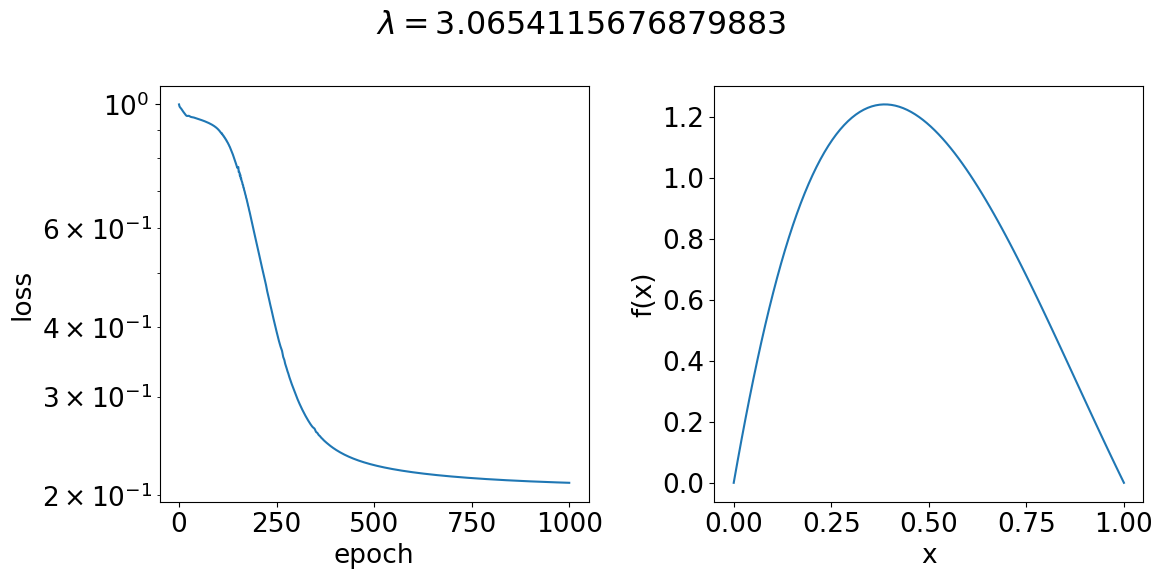

In [51]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []

optimizer = optim.Adam(ode.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01)**(1/2000))
x = torch.tensor(np.linspace(0, 1, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(1001):
    try:
        optimizer.zero_grad()

        loss = odeloss(x)
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())

        if epoch % 100 == 0:
            
            plt.suptitle(f'$\lambda = {ode.lam.item()}$')
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('f(x)')
            ax2.plot(x.cpu().detach().numpy(), ode(x).cpu().detach().numpy())
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()
            
    except KeyboardInterrupt:
        break